# ML Pipeline

This notebook contains the ML Pipeline for the model training

## Libraries and imports

In [28]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

from datetime import date

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json

In [29]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [30]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/05_datasets/df_base_dataset.parquet"
df =  pd.read_parquet(path)

path = "gs://storage-barsianize/05_datasets/df_to_pred.parquet"
df_to_pred =  pd.read_parquet(path)

In [31]:
# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label']

## Methods and functions

### Build and train pipelines

In [32]:
def build_pipelines(regressors, transformers):
    pipelines = {}

    for transformer in transformers:
        for algorithm,regressor in regressors.items():
            pipeline = Pipeline([
                ('preprocessing', transformer),
                ('reg',regressor)
            ])
            pipelines[algorithm + '_' + str(transformer)] = pipeline

    return pipelines

In [33]:
def build_models(regressors,parameters_dict, transformers):
    pipelines = build_pipelines(regressors, transformers)

    cvs = {}
    
    for transformer in transformers:
        for algorithm,parameters in parameters_dict.items():
            # create grid search object
            cv = GridSearchCV(pipelines[algorithm + '_' + str(transformer)], cv=5, param_grid=parameters, scoring='r2')
            cvs[algorithm + '_' + str(transformer)] = cv

    print(cvs)
    
    return cvs

In [34]:
def display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix):

    # define the cross-validation method (e.g. KFold with 5 folds)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # define the evaluation metrics (r2 score and mean squared error)
    scoring = {'r2': make_scorer(r2_score), 
               'mse': make_scorer(mean_squared_error),
               'xve': make_scorer(explained_variance_score),
               'MAPE': make_scorer(mean_absolute_percentage_error)}
    # perform cross-validation and get the scores
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(scores)
    scores['fit_time']  = scores['fit_time'].tolist() 
    scores['score_time']= scores['score_time'].tolist() 
    scores['test_r2']   = scores['test_r2'].tolist() 
    scores['test_mse']  = scores['test_mse'].tolist()
    scores['test_xve']  = scores['test_xve'].tolist()
    scores['test_MAPE'] = scores['test_MAPE'].tolist()

    print('CV R2 score:', np.mean(scores['test_r2']))
    print('CV MSE:', np.mean(scores['test_mse']))

    performance = {}

    test_score_r2 = r2_score(y_test, y_pred)
    test_score_mse = mean_squared_error(y_test, y_pred)
    test_score_xvs = explained_variance_score(y_test, y_pred)
    test_score_mape = mean_absolute_percentage_error(y_test, y_pred)

    print('test r2:', test_score_r2)
    print('test mse:', test_score_mse)
    print('test explained_variance_score:', test_score_xvs)
    print('test MAPE:', test_score_mape)

    performance['cv_scores'] = scores
    performance['test_scores'] = {}
    performance['test_scores']['r2'] = test_score_r2
    performance['test_scores']['mse'] = test_score_mse
    performance['test_scores']['explained_variance_score'] = test_score_xvs
    performance['test_scores']['MAPE'] = test_score_mape
    
    print('___________________________________')
        
    print("\nBest Parameters:", model.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':model.best_params_,
        'performance':performance,
        'features':X.columns.to_list()
    }

    patch = '../data/03_models/out/'
    filename = patch + f'{str(date.today())}_{algorithm}'

    # return performance
    if sufix != '':
        sufix_ = '_' + sufix
    else:
        sufix_ = sufix

    json.dump(performance, open(filename+f'_results{sufix_}.json', 'w'))   
    pickle.dump(model.best_estimator_, open(filename+f'{sufix_}.pkl', 'wb'))

    return test_score_r2

In [35]:
def train_models(df, params_path, label, regressors, transformers, cols_to_drop=None, cols_to_train=None, sufix=""):

    # separating the train and target features
    if cols_to_train == None:
        X = df.drop(cols_to_drop, axis=1)
    elif cols_to_train != None:
        print('here we go again')
        X = df[cols_to_train]
    else:
        raise

    y = df[label]

    with open(params_path) as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    models = build_models(regressors,parameters,transformers)

    for algorithm, model in models.items():
        # X, y = load_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

        print(algorithm)        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix)
        print(algorithm, r2)

    return models

### Load Models and assess results

In [36]:
def load_model(path, model_name):
    
    with open(path + model_name, 'rb') as file:
        model = pickle.load(file)

    loaded_model = None
    for step_name, step_model in model.named_steps.items():
        if isinstance(step_model, LGBMRegressor):
            loaded_model = step_model
            break
        elif isinstance(step_model, XGBRegressor):
            loaded_model = step_model
            break
        elif step_name == 'preprocessing':
            transformer = step_model

    return loaded_model, transformer

In [37]:
def make_predictions(path, model_name, results_file, X_to_pred):
    # model_name = '2023-08-04_LGBMRegressor_Normalizer()_feat_selection.pkl'
    with open(path + model_name, 'rb') as file:
        pipeline = pickle.load(file)

    with open(path + results_file, 'rb') as json_file:
        results = json.load(json_file)

    model, transformer = load_model(path, model_name)

    features = results['features']

    return pipeline.predict(X_to_pred[features]), pipeline, model, transformer, features

In [38]:
def get_feature_importances(model, model_class, features):
    if 'LGB' in model_class:
        feature_importances = model.booster_.feature_importance(importance_type='gain')
    elif 'XGB' in model_class:
        feature_importances = model.get_booster().get_score(importance_type='gain').values()
        
    # Create a dictionary to associate feature names with their importance scores
    feature_importance_dict = dict(zip(features, feature_importances))
    df_feature_importance = pd.DataFrame(feature_importance_dict, 
                                      index=['Total gain']).T.sort_values(by='Total gain', ascending=False)
    return df_feature_importance

In [39]:
def calculate_shap_values(model, transformer, X_train, X_test, path, filename, plot=False):
    # If the LightGBM model is found, convert it to a LightGBM Booster object and prepare the explainer
    if model is not None:
        # Assuming you have your test data in 'X_test' (replace 'X_test' with your actual test data)
        explainer = shap.Explainer(model, transformer.transform(X_train))

        # Calculate SHAP values for the test data
        shap_values = explainer(transformer.transform(X_test), check_additivity=False)

        # Save SHAP values to a file using pickle
        with open(path + filename, 'wb') as file:
            pickle.dump(shap_values, file)

        # plot shap summary if desired
        if plot:
            shap.summary_plot(shap_values, X_test)
        
        # Return SHAP values
        return shap_values
    
    else:
        print("LightGBM model not found in the pipeline.")
    

## Training Models

### Training baseline Version

#### Training Model

In [40]:
params_path = '../data/03_models/in/params.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

# separating the train and target features
X = df.drop(cols_to_drop, axis=1)
y = df[label]

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer()]

models = train_models(df, params_path, label, regressors, transformers, cols_to_drop)

{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.1, 0.01],
                         'reg__n_estimators': [100, 500],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsampl

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([35.16109848, 33.2146678 , 32.50200248, 32.08288884, 34.04251862]), 'score_time': array([0.0300076 , 0.03300738, 0.03200769, 0.03800845, 0.03300762]), 'test_r2': array([0.54918244, 0.5085822 , 0.23856614, 0.43153036, 0.601338  ]), 'test_mse': array([ 81.9922864 , 163.41141144, 216.46620649, 160.7880598 ,
        76.76855379]), 'test_xve': array([0.54926591, 0.50859646, 0.23856816, 0.43157046, 0.60134094]), 'test_MAPE': array([8.03124535e+14, 9.31458221e+14, 6.50509383e+14, 6.22978871e+14,
       6.54317867e+14])}
CV R2 score: 0.46583982801226426
CV MSE: 139.8853035840763
test r2: 0.33797658355448845
test mse: 124.26817509623423
test explained_variance_score: 0.3379767981201576
test MAPE: 610606037388144.1
___________________________________

Best Parameters: {'reg__learning_rate': 0.1, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.33797658355448845
XGBRegressor_Normalizer()
{'

### Assess Results from baseline Model

Load model

In [41]:
ref_date = date.today()
# ref_date = '2023-08-08'

path = '../data/03_models/out/'
model_name = f'{ref_date}_LGBMRegressor_Normalizer().pkl'
results_file = f'{ref_date}_LGBMRegressor_Normalizer()_results.json'

df_to_pred['dy_pred_LN'], lgb_pipeline, lgb_model, lgb_model_transformer, lgb_model_features = make_predictions(path, model_name, results_file, X_to_pred)



model_name = f'{ref_date}_XGBRegressor_Normalizer().pkl'
model_name = f'{ref_date}_XGBRegressor_Normalizer().pkl'
results_file = f'{ref_date}_XGBRegressor_Normalizer()_results.json'

df_to_pred['dy_pred_XN'], xgb_pipeline, xgb_model, xgb_model_transformer, xgb_model_features = make_predictions(path, model_name, results_file, X_to_pred)

Get feature importances based on Total Gain

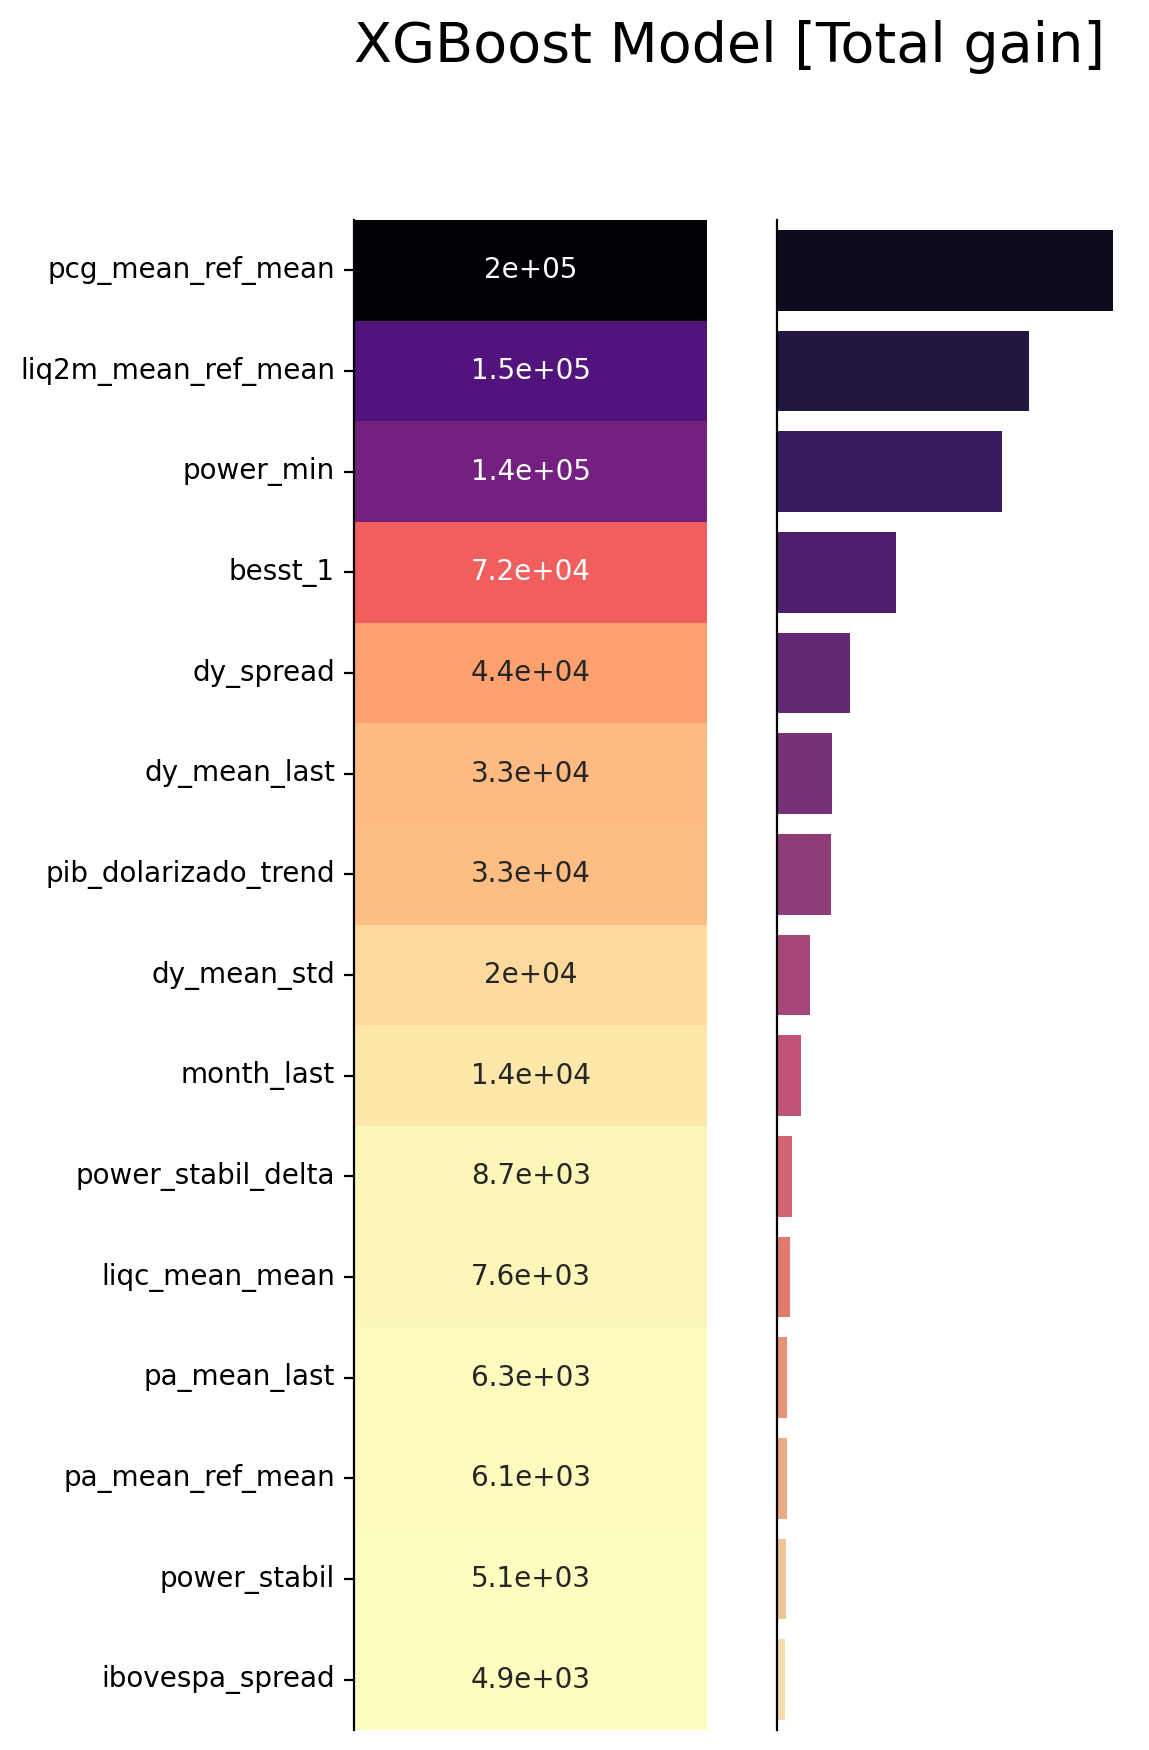

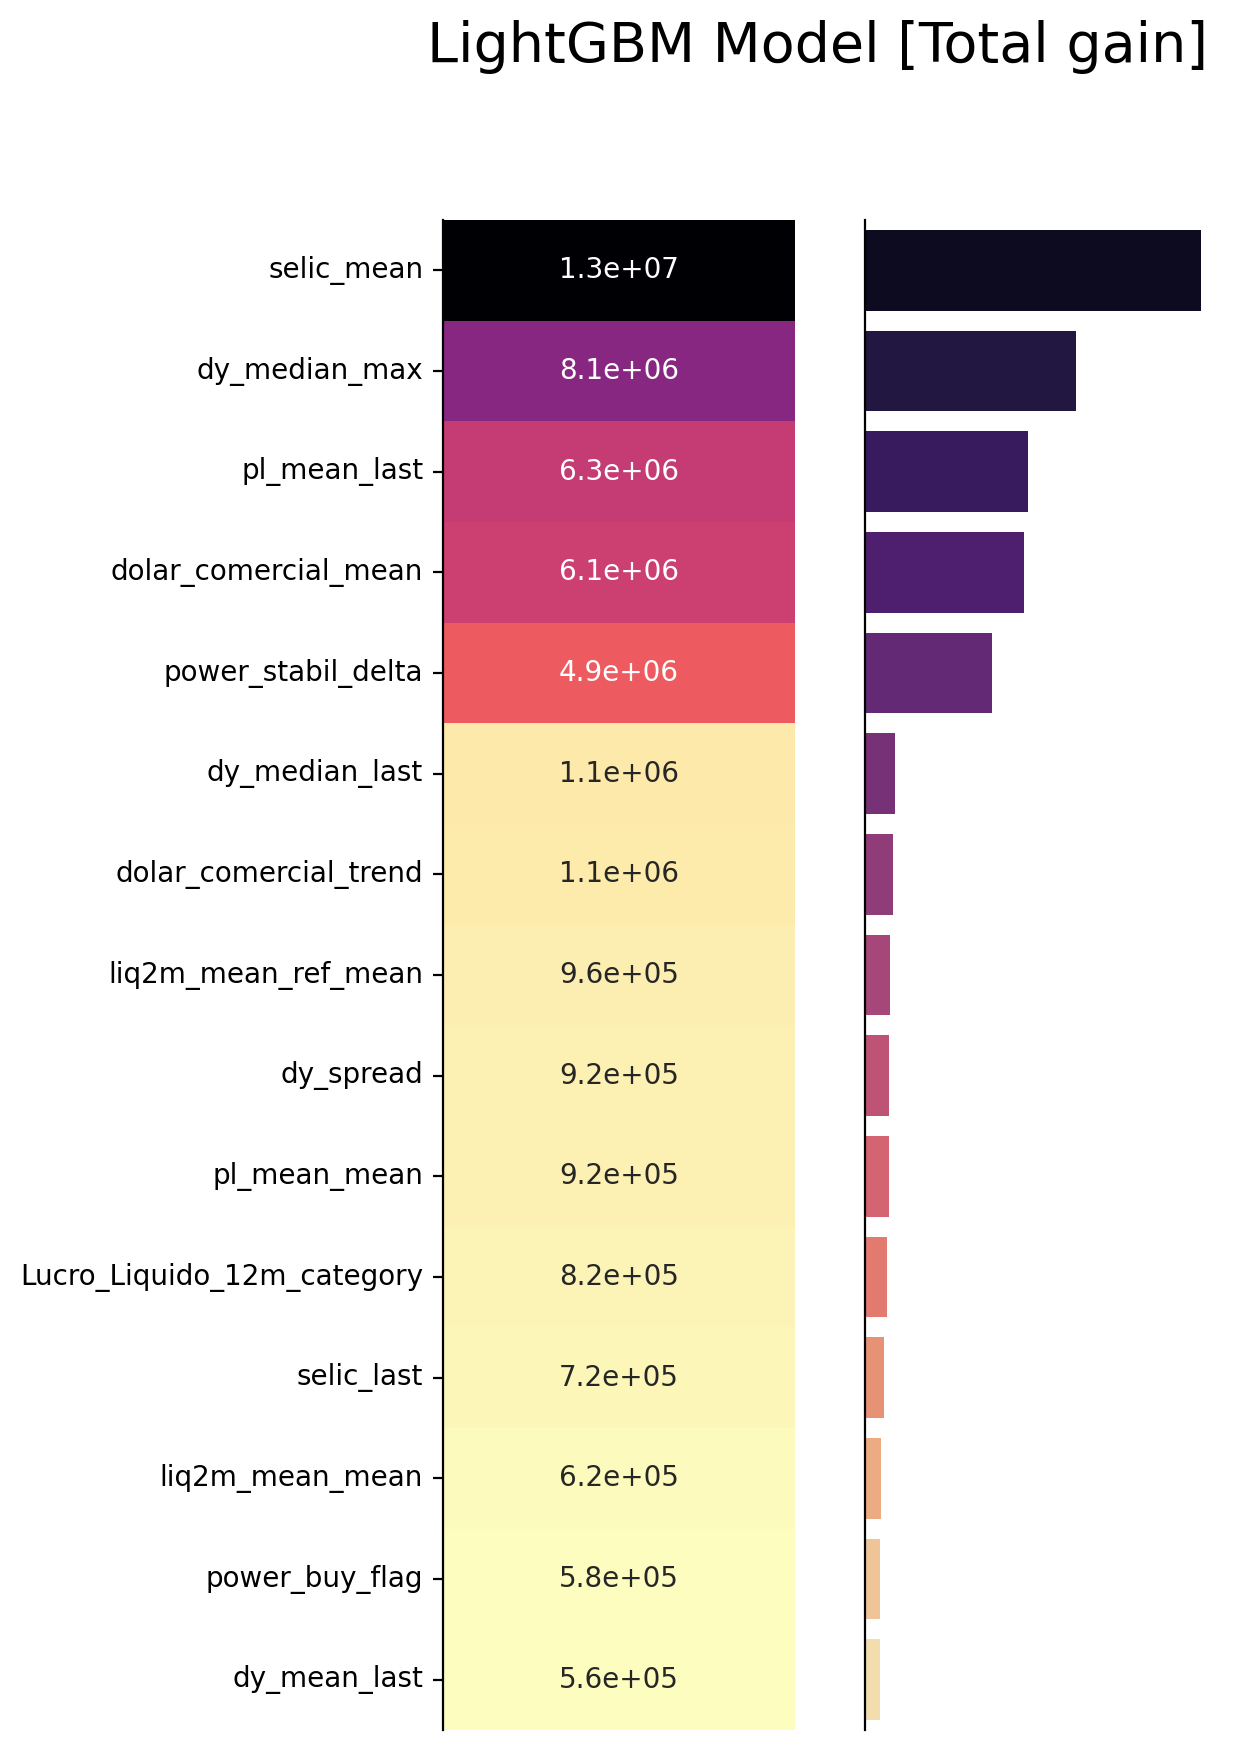

In [42]:
xgb_feature_importance = get_feature_importances(xgb_model, 'XGB', X.columns.to_list())
plot_importance(xgb_feature_importance, 'Total gain', 'XGBoost Model [Total gain]')

lgb_feature_importance = get_feature_importances(lgb_model, 'LGB', X.columns.to_list())
plot_importance(lgb_feature_importance, 'Total gain', 'LightGBM Model [Total gain]')

Get feature importances based on SHAP values

 99%|===================| 15105/15207 [02:20<00:00]        

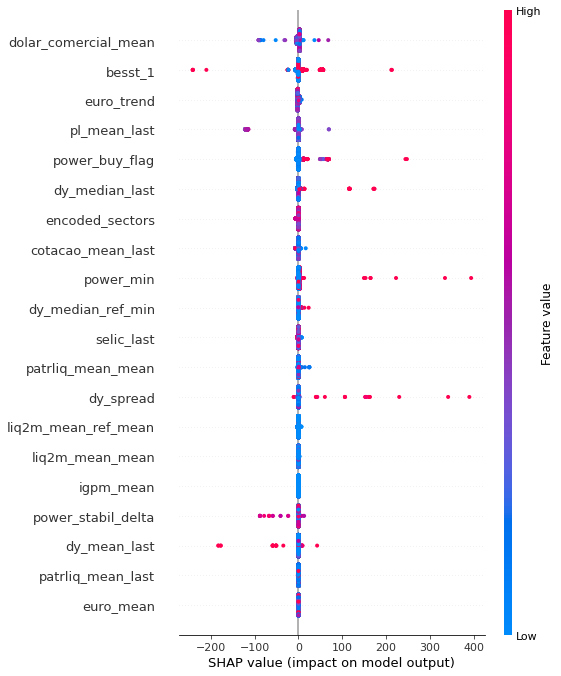

100%|===================| 15176/15207 [04:07<00:00]        

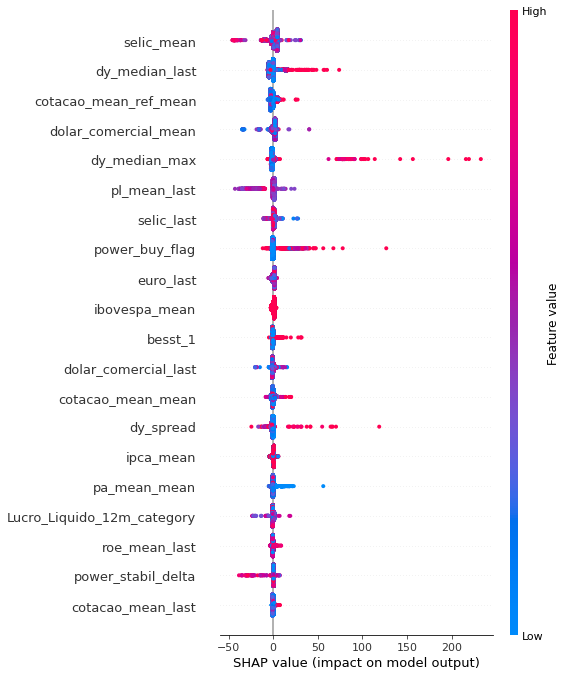

In [43]:
# ref_date = '2023-08-08'
ref_date = date.today()

X = df[xgb_model_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

path = '../data/03_models/out/'
file_name_shap = f'{ref_date}_XGBRegressor_Normalizer()_SHAP.pkl'

xgb_shap = calculate_shap_values(xgb_model, xgb_model_transformer, X_train, X_test, path, file_name_shap, plot=True)

# Save SHAP values to a file using pickle
with open(path + file_name_shap, 'wb') as file:
    pickle.dump(xgb_shap, file)




X = df[lgb_model_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

file_name_shap = f'{ref_date}_LGBMRegressor_Normalizer()_SHAP.pkl'

lgb_shap = calculate_shap_values(lgb_model, lgb_model_transformer, X_train, X_test, path, file_name_shap, plot=True)


# Save SHAP values to a file using pickle
with open(path + file_name_shap, 'wb') as file:
    pickle.dump(lgb_shap, file)

In [44]:
d = dict(zip(xgb_model_features,np.abs(np.sum(xgb_shap.values, axis=0))))
df_xgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

d = dict(zip(lgb_model_features,np.abs(np.sum(lgb_shap.values, axis=0))))
df_lgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

### Train feature selection model

Load baseline models' feature importance

In [45]:
# ref_date = '2023-08-08'
ref_date = date.today()

path = '../data/03_models/out/'


file_name_shap = f'{ref_date}_XGBRegressor_Normalizer()_SHAP.pkl'

with open(path + file_name_shap, 'rb') as file:
        xgb_shap = pickle.load(file)


file_name_shap = f'{ref_date}_LGBMRegressor_Normalizer()_SHAP.pkl'

with open(path + file_name_shap, 'rb') as file:
        lgb_shap = pickle.load(file)

Get the most important features from the XGBoost and LightGBM models, through the intersection of the first 60 features

In [46]:
n = 60

intersection_lgb_xgb = np.isin(df_lgb_shap.iloc[:n].index,df_xgb_shap.iloc[:n].index)
intersection_xgb_lgb = np.isin(df_xgb_shap.iloc[:n].index,df_lgb_shap.iloc[:n].index)
cols_to_train = df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index.to_list()

print('lgb in xgb ',np.mean(intersection_lgb_xgb))
print('xgb in lgb ',np.mean(intersection_xgb_lgb))
print('double check, cross intersection value', 
      np.isin(df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index,df_xgb_shap.iloc[:n].loc[intersection_xgb_lgb].index).mean())
print('\n\ncols to train:\n')
for col in  cols_to_train:
    print(col)

lgb in xgb  0.7333333333333333
xgb in lgb  0.7333333333333333
double check, cross intersection value 1.0


cols to train:

selic_mean
dy_median_max
dolar_comercial_mean
cotacao_mean_ref_mean
dy_spread
dy_median_last
selic_last
power_buy_flag
power_stabil_delta
pl_mean_last
euro_last
Lucro_Liquido_12m_category
dolar_comercial_last
cotacao_max_ref_max
euro_trend
cotacao_mean_last
roe_mean_last
cotacao_mean_mean
liq2m_mean_ref_mean
year_last
month_last
patrliq_mean_trend
pvp_mean_mean
besst_1
power_min
patrliq_mean_last
patrliq_mean_mean
pl_mean_mean
pvp_mean_last
c5y_mean_trend
roe_mean_trend
liq2m_mean_mean
pa_mean_mean
dolar_comercial_trend
pvp_mean_ref_mean
selic_trend
pib_dolarizado_trend
euro_mean
dy_mean_last
power_stabil
liqc_mean_last
encoded_sectors
dy_median_min
dy_median_ref_min


Train new feature selection model

In [47]:
params_path = '../data/03_models/in/params_optimized_lgbm.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer(),StandardScaler()]

models = train_models(df, params_path, label, regressors, transformers, 
                        cols_to_train=cols_to_train, 
                        sufix='feat_selection')

here we go again
{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.01, 0.5],
                         'reg__max_depth': [3, 5],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'LGBMRegressor_StandardScaler()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.01, 0.5],
                         'reg__max_depth': [3, 5],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2')}
LGBMRegressor_Normalizer()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([45.9724462 , 43.58590317, 41.58945036, 42.44264364, 42.93025947]), 'score_time': array([0.02900648, 0.02900672, 0.02800632, 0.02900672, 0.03500819]), 'test_r2': array([0.68844624, 0.70291708, 0.39777649, 0.70392012, 0.84596892]), 'test_mse': array([ 56.66373182,  98.78913393, 171.20467893,  83.74433216,
        29.66107367]), 'test_xve': array([0.68867412, 0.70291906, 0.39779777, 0.703948  , 0.84597134]), 'test_MAPE': array([6.87321735e+14, 8.21347274e+14, 2.84256654e+14, 3.56670873e+14,
       4.41432802e+14])}
CV R2 score: 0.6678057690808753
CV MSE: 88.01259010431923
test r2: 0.32164824272984527
test mse: 127.33316202301425
test explained_variance_score: 0.32165120067885145
test MAPE: 952717658908595.9
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 5, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.32164824272984527
LGBMRe

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([40.53819966, 40.73923993, 40.56120038, 40.58420539, 43.02727628]), 'score_time': array([0.02900672, 0.03600788, 0.04601073, 0.05101132, 0.06101418]), 'test_r2': array([0.65561887, 0.80373362, 0.42549683, 0.69944911, 0.87416244]), 'test_mse': array([ 62.63419876,  65.26455929, 163.32412831,  85.00892748,
        24.23197484]), 'test_xve': array([0.65580279, 0.80373653, 0.42552088, 0.69947197, 0.87416711]), 'test_MAPE': array([5.42352775e+14, 9.64858588e+14, 3.89575127e+14, 3.45870402e+14,
       4.95498953e+14])}
CV R2 score: 0.6916921736414978
CV MSE: 80.09275773556328
test r2: 0.24541926365004307
test mse: 141.64207600457235
test explained_variance_score: 0.24542424691619136
test MAPE: 1207292090454926.8
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 3, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_StandardScaler() 0.24541926365004307


In [48]:
n = 30

intersection_lgb_xgb = np.isin(df_lgb_shap.iloc[:n].index,df_xgb_shap.iloc[:n].index)
intersection_xgb_lgb = np.isin(df_xgb_shap.iloc[:n].index,df_lgb_shap.iloc[:n].index)
cols_to_train = df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index.to_list()

print('lgb in xgb ',np.mean(intersection_lgb_xgb))
print('xgb in lgb ',np.mean(intersection_xgb_lgb))
print('double check, cross intersection value', 
      np.isin(df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index,df_xgb_shap.iloc[:n].loc[intersection_xgb_lgb].index).mean())
print('\n\ncols to train:\n')
for col in  cols_to_train:
    print(col)

lgb in xgb  0.6666666666666666
xgb in lgb  0.6666666666666666
double check, cross intersection value 1.0


cols to train:

selic_mean
dy_median_max
dolar_comercial_mean
dy_spread
dy_median_last
selic_last
power_buy_flag
power_stabil_delta
pl_mean_last
euro_last
euro_trend
cotacao_mean_last
roe_mean_last
liq2m_mean_ref_mean
month_last
pvp_mean_mean
besst_1
power_min
patrliq_mean_last
patrliq_mean_mean


In [49]:
params_path = '../data/03_models/in/params_optimized_lgbm.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer(),StandardScaler()]

models = train_models(df, params_path, label, regressors, transformers, 
                        cols_to_train=cols_to_train, 
                        sufix='feat_selection_lgbm')

here we go again
{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.01, 0.5],
                         'reg__max_depth': [3, 5],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'LGBMRegressor_StandardScaler()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.01, 0.5],
                         'reg__max_depth': [3, 5],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2')}
LGBMRegressor_Normalizer()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([33.45658851, 33.19452858, 31.12706017, 32.48136711, 32.30232668]), 'score_time': array([0.02500534, 0.02500582, 0.02600646, 0.02400565, 0.02500582]), 'test_r2': array([0.62740835, 0.70006087, 0.40747553, 0.67655565, 0.79850034]), 'test_mse': array([ 67.76497581,  99.73891101, 168.44736015,  91.48420038,
        38.80188618]), 'test_xve': array([0.62749647, 0.70006659, 0.40749274, 0.6765665 , 0.79850047]), 'test_MAPE': array([5.86309420e+14, 7.08612161e+14, 3.40834191e+14, 3.02226747e+14,
       4.25013022e+14])}
CV R2 score: 0.6420001484077295
CV MSE: 93.24746670574812
test r2: 0.2953773333998797
test mse: 132.26446487342054
test explained_variance_score: 0.29538393095217186
test MAPE: 881092746118036.9
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 5, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.2953773333998797
LGBMRegr

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([29.90978384, 29.79275775, 28.86254621, 29.75574899, 29.53369904]), 'score_time': array([0.03300738, 0.0260067 , 0.02500582, 0.03600836, 0.02500558]), 'test_r2': array([0.59483365, 0.70298276, 0.39116229, 0.62992996, 0.75202293]), 'test_mse': array([ 73.68948902,  98.76729309, 173.08501267, 104.67198285,
        47.75183275]), 'test_xve': array([0.59493052, 0.7029828 , 0.39117685, 0.62996635, 0.75202298]), 'test_MAPE': array([5.71102676e+14, 9.09905334e+14, 4.68829478e+14, 4.06945214e+14,
       4.82450401e+14])}
CV R2 score: 0.6141863172481511
CV MSE: 99.59312207485122
test r2: 0.21550962246434346
test mse: 147.25640389026273
test explained_variance_score: 0.21551027576550696
test MAPE: 997329607357548.1
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 5, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_StandardScaler() 0.21550962246434346
